In [71]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing = fetch_california_housing()

In [72]:
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data["MedHouseVal"] = housing.target

In [73]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [75]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


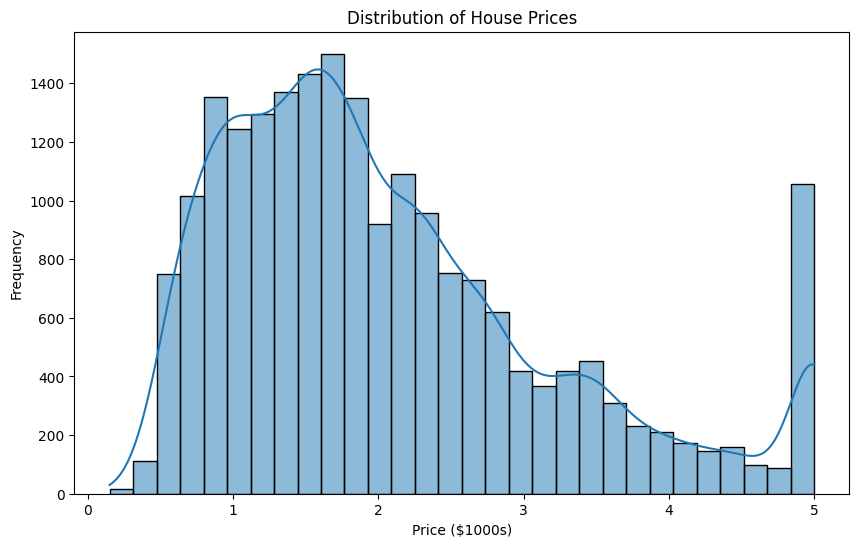

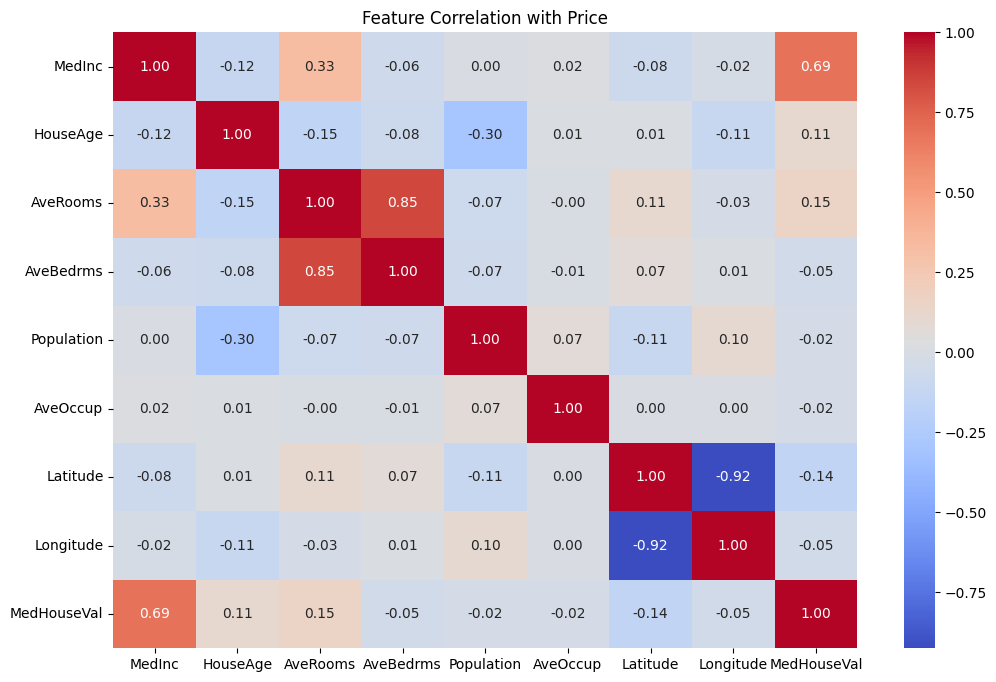

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(data['MedHouseVal'], bins=30, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price ($1000s)')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation with Price')
plt.show()


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = data.drop(columns=['MedHouseVal'])
y = data['MedHouseVal']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [84]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = SimpleNN(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [87]:
# if you want to save model weights to compare the loss with candle version of the model
from safetensors.torch import save_file
save_file(model.state_dict(), "pytorch_model.safetensors")

Epoch 1/500, Loss: 5.6357
Epoch 51/500, Loss: 0.5123
Epoch 101/500, Loss: 0.4119
Epoch 151/500, Loss: 0.3833
Epoch 201/500, Loss: 0.3619
Epoch 251/500, Loss: 0.3423
Epoch 301/500, Loss: 0.3271
Epoch 351/500, Loss: 0.3158
Epoch 401/500, Loss: 0.3075
Epoch 451/500, Loss: 0.3012
Epoch 500/500, Loss: 0.2959


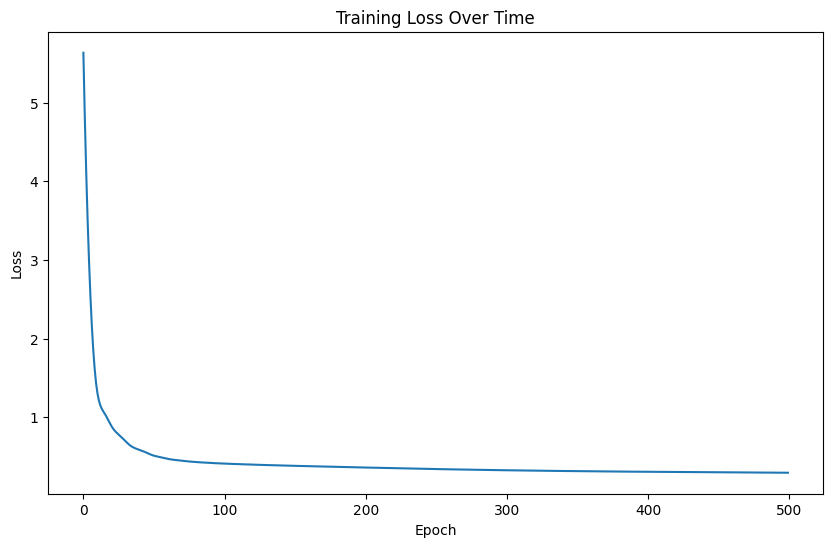

In [89]:
# Training loop
epochs = 500
losses = []

for epoch in range(epochs):
    model.train()
    
    # Convert to tensors
    inputs = torch.tensor(X_train, dtype=torch.float32)
    targets = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if (epoch) % 50 == 0 or epoch == epochs-1:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


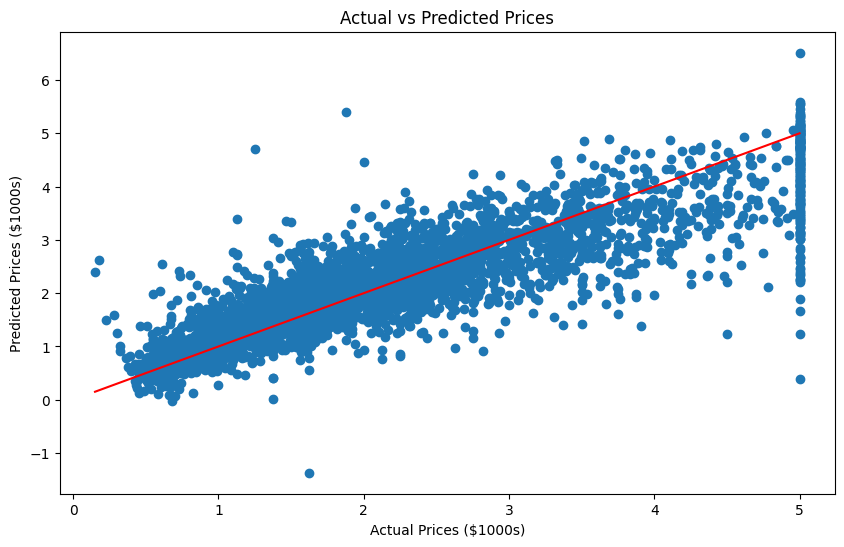

In [90]:
model.eval()

# Predict on test set
with torch.no_grad():
    test_inputs = torch.tensor(X_test, dtype=torch.float32)
    predictions = model(test_inputs).numpy()

# Plot predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Prices ($1000s)')
plt.ylabel('Predicted Prices ($1000s)')
plt.title('Actual vs Predicted Prices')
plt.show()


In [41]:
X_train.shape, X_test.shape

((16512, 8), (4128, 8))

In [42]:
y_train.shape, y_test.shape

((16512,), (4128,))

In [46]:
a = {
    "X_train": X_train.tolist(),
    "y_train": y_train.tolist(),
    "X_test": X_test.tolist(),
    "y_test": y_test.tolist()
}

In [48]:
import json

In [49]:
with open("/Users/wynum_air/Downloads/fetch_california_housing.json","w")as f:
    json.dump(a,f)